In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai pymongo[srv]==3.12

In [1]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

## Define tools

In [2]:
from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from pymongo import MongoClient
from datetime import datetime

import os
import json
from bson import json_util

# Define tools
@tool
def get_sales_data(query: dict = None):
    """Get sales data from MongoDB using flexible query parameters.
    
    Args:
        query: Custom MongoDB query dict to execute directly
    """    
    
    mongo_query = query
    
    uri = os.getenv("MONGODB_URI")
    if not uri:
        return "Error: MongoDB URI not found in environment variables"
        
    try:
        client = MongoClient(uri)
        database = client.get_database("mongodbVSCodePlaygroundDB")
        collection = database.get_collection("sales")
        
        # Execute the query with options
        cursor = collection.find(mongo_query)
        sales_data = list(cursor)
        
        # Convert results to a readable format (handle MongoDB ObjectId and Date objects)
        results = json.loads(json_util.dumps(sales_data))
        
        client.close()
        
        if not sales_data:
            return f"No sales found for query: {mongo_query}"  
        
        return {
            "count": len(sales_data),
            "query": mongo_query,
            "sales": results
        }
    
    except Exception as e:
        return f"Error retrieving sales data: {str(e)}"

In [3]:
from langchain_core.messages import AIMessage

# Create a tool node with the get_sales_data tool
tool_node = ToolNode([get_sales_data])

# Test with a query for 2014 sales
query = {'item': 'xyz'}

print("\nMethod using AIMessage with tool calls")
tool_call_message = AIMessage(
    content="",
    tool_calls=[
        {
            "id": "1",
            "type": "function",
            "name": "get_sales_data",
            "args": {
                "query": query
            }
        }
    ]
)

result = tool_node.invoke({"messages": [tool_call_message]})
print("Tool node result: " + str(result))


Method using AIMessage with tool calls
Tool node result: {'messages': [ToolMessage(content='{"count": 2, "query": {"item": "xyz"}, "sales": [{"_id": {"$oid": "6837860f55e9e6698ee5a770"}, "item": "xyz", "price": 5, "quantity": 10, "date": {"$date": "2014-03-15T09:00:00Z"}}, {"_id": {"$oid": "6837860f55e9e6698ee5a771"}, "item": "xyz", "price": 5, "quantity": 20, "date": {"$date": "2014-04-04T11:21:39.736Z"}}]}', name='get_sales_data', tool_call_id='1')]}
Tool node result: {'messages': [ToolMessage(content='{"count": 2, "query": {"item": "xyz"}, "sales": [{"_id": {"$oid": "6837860f55e9e6698ee5a770"}, "item": "xyz", "price": 5, "quantity": 10, "date": {"$date": "2014-03-15T09:00:00Z"}}, {"_id": {"$oid": "6837860f55e9e6698ee5a771"}, "item": "xyz", "price": 5, "quantity": 20, "date": {"$date": "2014-04-04T11:21:39.736Z"}}]}', name='get_sales_data', tool_call_id='1')]}


## Define MongoDB Query Agent

In [8]:
from typing import Literal
from langchain_openai import AzureChatOpenAI
from langgraph.types import Command
import re

def mongo_query_agent(state) -> Command[Literal["__end__"]]:
    """Agent that processes user queries about sales data and uses LLM to generate a mongo query based on schema."""
    
    # Extract the user message
    user_message = state["messages"][-1].content
    
    # Define the MongoDB schema for the LLM
    schema_info = """
    MongoDB Collection Schema:
    {
        'item': string,      // Product identifier like 'abc', 'xyz', etc.
        'price': number,     // Price of the item (e.g., 10, 7.5)
        'quantity': number,  // Number of items sold (e.g., 5, 10)
        'date': Date     // Date of the sale in ISO format 
    }
    """

    # Create system prompt for the LLM
    system_prompt = f"""
        You are a MongoDB query assistant. Based on user requests, generate appropriate MongoDB queries.
        {schema_info}

        Analyze the user query, determine what information they need from the sales data, and formulate a MongoDB query dictionary.
        Your response should be a valid Python dictionary that can be used as a MongoDB query.
        
        IMPORTANT: Return ONLY the Python dictionary without any additional text, markdown formatting, or code blocks.
        
        For example, if the user asks about sales in 2014, you might return: 
        {{'date': {{'$gte': datetime(2014, 1, 1), '$lt': datetime(2015, 1, 1)}}}}
        
        If they ask about an item 'xyz', you might return:
        {{'item': 'xyz'}}
        
        Be specific and precise with your queries.
        """

    # Call the LLM to analyze the user query
    llm = AzureChatOpenAI(
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
        openai_api_version="2024-12-01-preview",
    )
    
    chat_prompt = [{"role": "system", "content": system_prompt}, 
                  {"role": "user", "content": f"Generate a MongoDB query for: {user_message}"}]
    
    llm_response = llm.invoke(chat_prompt)
    query_str = llm_response.content
    
    # Clean up the response - remove markdown code blocks if present
    query_str = re.sub(r'```(?:python|json)?\n?', '', query_str)
    query_str = re.sub(r'```\n?', '', query_str)
    query_str = query_str.strip()
    
    print("Generated MongoDB query:", query_str)
    
    # Return the result with a tool call to get_sales_data
    return {"messages": state["messages"] + [AIMessage(
        content="",
        tool_calls=[
            {
                "id": "1",
                "type": "function",
                "name": "get_sales_data",
                "args": {
                    "query": eval(query_str)  # Convert string representation to dict
                }
            }
        ]
    )]}

## Define an approval agent

In [12]:
from typing import Literal
import json
from langchain_core.tools import tool

# Mock approval/denial API tools
@tool
def approve_request(data: dict):
    """Approve a request based on the given data.
    
    Args:
        data: The data supporting the approval decision
    """
    return f"Request APPROVED with {data['count']} matching records found"

@tool
def deny_request(reason: str):
    """Deny a request with a provided reason.
    
    Args:
        reason: The reason for denial
    """
    return f"Request DENIED. Reason: {reason}"

# Approval agent that evaluates MongoDB query results
def approval_agent(state) -> Command[Literal["__end__"]]:
    """Agent that evaluates the MongoDB query results and makes approval decisions."""
    
    # Get the latest message which should be the tool execution result from get_sales_data
    last_message = state["messages"][-1]
    
    # Check if the message has content or tool outputs
    if hasattr(last_message, "tool_outputs") and last_message.tool_outputs:
        # Get the tool output content
        result_content = last_message.tool_outputs[0]["content"]
        
        # Try to parse the result as JSON if it's a string
        if isinstance(result_content, str):
            try:
                result_data = json.loads(result_content)
            except json.JSONDecodeError:
                # If it's not valid JSON, check if it contains "No sales found"
                if "No sales found" in result_content:
                    return {"messages": state["messages"] + [AIMessage(
                        content="",
                        tool_calls=[{
                            "id": "1",
                            "type": "function",
                            "name": "deny_request",
                            "args": {"reason": "No matching records found"}
                        }]
                    )]}
                else:
                    return {"messages": state["messages"] + [AIMessage(
                        content="",
                        tool_calls=[{
                            "id": "1",
                            "type": "function",
                            "name": "deny_request",
                            "args": {"reason": f"Error processing result: {result_content}"}
                        }]
                    )]}
        else:
            # If it's already a dict or other object
            result_data = result_content
            
        # Check if we have sales data with records
        if isinstance(result_data, dict) and result_data.get("count", 0) > 0:
            return {"messages": state["messages"] + [AIMessage(
                content="",
                tool_calls=[{
                    "id": "1",
                    "type": "function",
                    "name": "approve_request",
                    "args": {"data": result_data}
                }]
            )]}
        else:
            # No records or invalid format
            return {"messages": state["messages"] + [AIMessage(
                content="",
                tool_calls=[{
                    "id": "1",
                    "type": "function",
                    "name": "deny_request",
                    "args": {"reason": "No matching records found or invalid data format"}
                }]
            )]}
    else:
        # Handle case where there's no tool output
        return {"messages": state["messages"] + [AIMessage(
            content="",
            tool_calls=[{
                "id": "1",
                "type": "function",
                "name": "deny_request",
                "args": {"reason": "No result data received from query"}
            }]
        )]}


## build the graph

In [13]:
from langgraph.graph import StateGraph, MessagesState, START

# Create a tool node for the approval/denial tools
approval_tool_node = ToolNode([approve_request, deny_request])

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("mongo_query_agent", mongo_query_agent)
builder.add_node("tool_executor", tool_node)
builder.add_node("approval_agent", approval_agent)
builder.add_node("approval_tool_executor", approval_tool_node)

builder.add_edge(START, "mongo_query_agent")
builder.add_edge("mongo_query_agent", "tool_executor")
builder.add_edge("tool_executor", "approval_agent")
builder.add_edge("approval_agent", "approval_tool_executor")
builder.add_edge("approval_tool_executor", "__end__")

network = builder.compile()

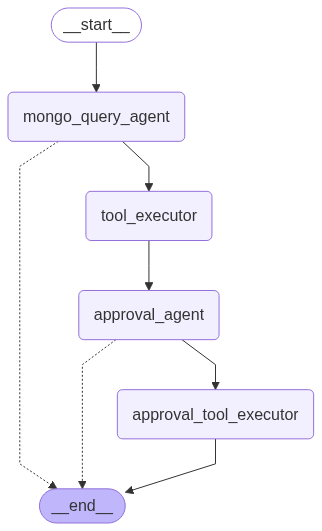

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        network.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [16]:
# Test the agent with some example queries
from langchain_core.messages import HumanMessage

# Example: Query for a specific item in 2014
response = network.invoke({"messages": [HumanMessage(content="How many xyz items were sold in 2014?")]})
print("\nQuery Response:")
print(response["messages"][-1].content)

# Show all messages in the chain to see the approval decision
print("\nComplete message chain:")
for i, msg in enumerate(response["messages"]):
    print(f"\nMessage {i+1} ({msg.__class__.__name__}):")
    if hasattr(msg, "content") and msg.content:
        print(f"Content: {msg.content}")
    if hasattr(msg, "tool_calls") and msg.tool_calls:
        print(f"Tool calls: {msg.tool_calls}")
    if hasattr(msg, "tool_outputs") and msg.tool_outputs:
        print(f"Tool outputs: {msg.tool_outputs}")

Generated MongoDB query: {'item': 'xyz', 'date': {'$gte': datetime(2014, 1, 1), '$lt': datetime(2015, 1, 1)}}

Query Response:
Request DENIED. Reason: No result data received from query

Complete message chain:

Message 1 (HumanMessage):
Content: How many xyz items were sold in 2014?

Message 2 (AIMessage):
Tool calls: [{'name': 'get_sales_data', 'args': {'query': {'item': 'xyz', 'date': {'$gte': datetime.datetime(2014, 1, 1, 0, 0), '$lt': datetime.datetime(2015, 1, 1, 0, 0)}}}, 'id': '1', 'type': 'tool_call'}]

Message 3 (ToolMessage):
Content: {'count': 2, 'query': {'item': 'xyz', 'date': {'$gte': datetime.datetime(2014, 1, 1, 0, 0), '$lt': datetime.datetime(2015, 1, 1, 0, 0)}}, 'sales': [{'_id': {'$oid': '6837860f55e9e6698ee5a770'}, 'item': 'xyz', 'price': 5, 'quantity': 10, 'date': {'$date': '2014-03-15T09:00:00Z'}}, {'_id': {'$oid': '6837860f55e9e6698ee5a771'}, 'item': 'xyz', 'price': 5, 'quantity': 20, 'date': {'$date': '2014-04-04T11:21:39.736Z'}}]}

Message 4 (AIMessage):
Tool 

In [ ]:
# Test with more examples
from langchain_core.messages import HumanMessage

# Example 1: Query for a specific item with price (should be approved if records exist)
response1 = network.invoke({"messages": [HumanMessage(content="Find all sales of item abc where price was greater than 15")]})
print("\nQuery 1 Final Response:")
print(response1["messages"][-1].content)

# Example 2: Query that should return no results (should be denied)
response2 = network.invoke({"messages": [HumanMessage(content="Find sales for item that doesn't exist in January 3000")]})
print("\nQuery 2 Final Response:")
print(response2["messages"][-1].content)

# Example 3: Another example that should return results
response3 = network.invoke({"messages": [HumanMessage(content="What were the total sales in January 2015?")]})
print("\nQuery 3 Final Response:")
print(response3["messages"][-1].content)


Generated MongoDB query: {'item': 'abc', 'price': {'$gt': 15}}

Query 1 Response:
No sales found for query: {'item': 'abc', 'price': {'$gt': 15}}
Generated MongoDB query: {'date': {'$gte': datetime(2015, 1, 1), '$lt': datetime(2015, 2, 1)}}

Query 2 Response:
No sales found for query: {'date': {'$gte': datetime.datetime(2015, 1, 1, 0, 0), '$lt': datetime.datetime(2015, 2, 1, 0, 0)}}
Generated MongoDB query: {'date': {'$gte': datetime(2015, 1, 1), '$lt': datetime(2015, 2, 1)}}

Query 2 Response:
No sales found for query: {'date': {'$gte': datetime.datetime(2015, 1, 1, 0, 0), '$lt': datetime.datetime(2015, 2, 1, 0, 0)}}


In [ ]:
# Create a function to test both approval and denial scenarios
def test_approval_scenarios():
    # Test scenario that should result in approval (query returns results)
    print("\n=== APPROVAL TEST SCENARIO ===")
    approval_response = network.invoke({"messages": [HumanMessage(content="Find all sales of item xyz")]})
    
    # Print only the final approval/denial message
    for msg in approval_response["messages"]:
        if hasattr(msg, "tool_outputs") and msg.tool_outputs and "APPROVED" in msg.tool_outputs[0]["content"]:
            print(f"\nFinal decision: {msg.tool_outputs[0]['content']}")
    
    # Test scenario that should result in denial (query returns no results)
    print("\n=== DENIAL TEST SCENARIO ===")
    denial_response = network.invoke({"messages": [HumanMessage(content="Find sales of item does_not_exist")]})
    
    # Print only the final approval/denial message
    for msg in denial_response["messages"]:
        if hasattr(msg, "tool_outputs") and msg.tool_outputs and "DENIED" in msg.tool_outputs[0]["content"]:
            print(f"\nFinal decision: {msg.tool_outputs[0]['content']}")

# Run the test scenarios
test_approval_scenarios()